# Unconfined Aquifer Practical
This practical is a jupyter notebook version of Tutorial 2 of Flopy for demostrator purposes ONLY.

The idea is that the students should be aware of how the orginal script functions. Please DO NOT give them the answer contained within here => Direct them to the manual pages (documentation) of Flopy and walk away. Give them a couple of minutes and come back in about 5 minutes once they have had a go and check they have been able to work it out. Support them reading the documentation and discuss approaches.

If they have gone through the script like I asked them to last week (and like some have done) this should be a walk in a metaphorical park.

In [60]:
%matplotlib inline  
import numpy as np                                                                  
import flopy

### Discretization
We start by creating our flopy model object as follows:

For week 2 I have changed the modelname from 'confined' to 'unconfined'

In [61]:
# Assign name and create modflow model object                                    
modelname = 'unconfined'                                                          
mf = flopy.modflow.Modflow(modelname, exe_name='/Applications/ModflowExecutibles/mf2005')   

This block is the same as last week -> do not touch!

In [62]:
# Model domain and grid definition
# What do each one of these lines do? 
Lx = 1000.                                                                       
Ly = 1000.                                                                       
ztop = 0.                                                                        
zbot = -50.                                                                      
nlay = 1                                                                         
nrow = 10                                                                        
ncol = 10                                                                        
delr = Lx/ncol                                                                   
delc = Ly/nrow                                                                   
delv = (ztop - zbot) / nlay                                                      
botm = np.linspace(ztop, zbot, nlay + 1)  

They need to add the new timestep information in here (or at least before invoking the dis object).

In [63]:
# Time step parameters
nper = 3
perlen = [1, 100, 100]
nstp = [1, 100, 100]
steady = [True, False, False]

Adding ,nper=nper, perlen=perlen, nstp=nstp, steady=steady to the end of the dis object

In [64]:
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:],nper=nper, perlen=perlen, nstp=nstp, steady=steady)

## Basic Package

Very simiply we remove the following

ibound[:, :, 0] = -1

ibound[:, :, -1] = -1

AND

strt[:, :, 0] = 10.

strt[:, :, -1] = 0.

THEN WE ALSO multiply np.ones by 10

strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)




In [65]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

## Layer-Property Flow Package

add the following as a new set of variables

If they have a look at the manual it should be very straightforward to figure out what to do here

in the old version 

lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., ipakcb=53)

hk=10. is described explicity - I've just moved it to a new variable

In [66]:
hk = 10.
vka = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1

Ammend lpf from the following

lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., ipakcb=53) 

In [67]:
# Add LPF package to the MODFLOW model                                           
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp)

# Transient General-Head Boundary Package

Adding in details about the transient general head boundary package

In [68]:
# Make list for stress period 1
stageleft = 10.
stageright = 10.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print ('Adding ', len(bound_sp1), 'GHBs for stress period 1.')

# Make list for stress period 2
stageleft = 10.
stageright = 0.
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print ('Adding ', len(bound_sp2), 'GHBs for stress period 2.')

# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stess period 2 and apply it
# to the end of the simulation, if necessary
stress_period_data = {0: bound_sp1, 1: bound_sp2}

# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)


Adding  20 GHBs for stress period 1.
Adding  20 GHBs for stress period 2.


# Create the transient well package

This is new, again another copy and paste job

In [69]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -100.
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

## Output Control

Details on the flopy OC class are at: http://modflowpy.github.io/flopydoc/mfoc.html. Here we can use the default OC settings by specifying the following:

I think all we do here is just lose compact=True

In [70]:
# Output control
spd = {(0, 0): ['print head', 'save head', 'print budget', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)


## Preconditioned Conjugate Gradient Package

Details on the flopy PCG class are at: http://modflowpy.github.io/flopydoc/mfpcg.html. The default settings used by flopy will be used by specifying the following commands:


In [71]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf)

## Writing the MODFLOW Data Files

The MODFLOW input data files are written by simply issuing the following:

In [72]:
# Write the MODFLOW model input files
mf.write_input()

## Running the Modeling
If they have problems here likely that executible is in the wrong location

In [73]:

# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


## Post-Processing the Results
OK post processing is a copy and paste job

Levels:  [1 2 3 4 5 6 7 8 9]
Extent:  (50.0, 950.0, 50.0, 950.0)
*****Processing time:  1.0
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0


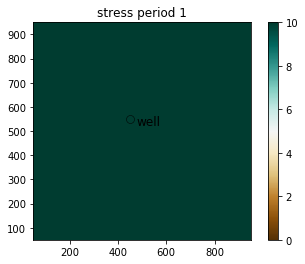

*****Processing time:  101.0
Head statistics
  min:  0.0110885
  max:  9.99076
  std:  3.18494


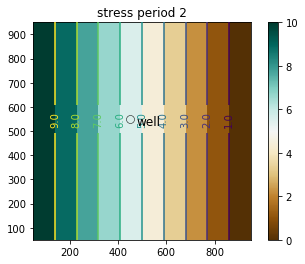

*****Processing time:  201.0
Head statistics
  min:  0.0109783
  max:  9.9907
  std:  3.18382


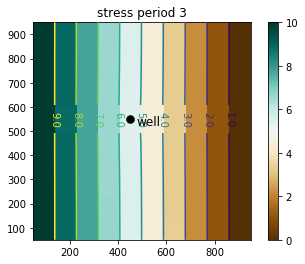

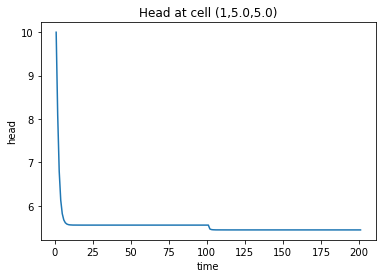

In [74]:
#Import the libraries
import matplotlib.pyplot as plt                                                  
import flopy.utils.binaryfile as bf   

# Create the headfile object
headobj = bf.HeadFile(modelname+'.hds')
times = headobj.get_times()

# Setup contour parameters
levels = np.arange(1, 10, 1) # same as tutorial 1
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)	# same as tutorial 1
print ('Levels: ', levels)
print ('Extent: ', extent)
# Well point
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
wpt = (450., 550.)

# Make the plots
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print ('*****Processing time: ', time)
    head = headobj.get_data(totim=time)
    #Print statistics
    print ('Head statistics')
    print ('  min: ', head.min())
    print ('  max: ', head.max())
    print ('  std: ', head.std())

    #Create the plot
    #plt.subplot(1, len(mytimes), iplot + 1, aspect='equal')
    plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1)) # plot title
    plt.imshow(head[0, :, :], extent=extent, cmap='BrBG', vmin=0., vmax=10.)
    plt.colorbar() # plot colourbar
    CS = plt.contour(np.flipud(head[0, :, :]), levels=levels, extent=extent,
                     zorder=10)
    plt.clabel(CS, inline=1, fontsize=10, fmt='%1.1f', zorder=11)	# plot contour label
    mfc = 'None'
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8,
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor=mfc, zorder=9)
    plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12, zorder=12)
    plt.show()

plt.show() # same as tutorial1

# Plot the head versus time
idx = (0, nrow/2 - 1, ncol/2 - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1])
plt.show()
